In [3]:
import sys
print(sys.executable)

/home/ubuntu/Desktop/kriyesh/datascience/.venv/bin/python


In [4]:
import sys
!{sys.executable} -m pip install requests

  Using cached requests-2.32.4-py3-none-any.whl (64 kB)
  Using cached certifi-2025.8.3-py3-none-any.whl (161 kB)
  Using cached urllib3-2.2.3-py3-none-any.whl (126 kB)
  Using cached charset_normalizer-3.4.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (147 kB)
  Using cached idna-3.10-py3-none-any.whl (70 kB)


In [6]:
import sys
!{sys.executable} -m pip install scikit-learn

In [4]:
#---General Purpose Imports---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import requests

#---Sckit-learn Imports---

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris, load_digits, make_moons, make_swiss_roll,fetch_openml
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score 


#---- Interactive widgets ----
import ipynb as widgets
from IPython.display import display, clear_output


#----- Plotting and Environment setup ----
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_context("notebook", font_scale=1.2)
warnings.filterwarnings("ignore")

print("all imports done")

all imports done


In [5]:
def fetch_pokemon(limit: int = 386) -> pd.DataFrame:
    """Fetches Pokémon data from the PokéAPI and returns a DataFrame."""
    records = []
    base_url = "https://pokeapi.co/api/v2/pokemon"
    
    print(f"Fetching data for the first {limit} Pokémon...")
    
    # 1️⃣  Grab the list of Pokémon
    list_resp = requests.get(f"{base_url}?limit={limit}", timeout=30)
    list_resp.raise_for_status()
    pokemon_list = list_resp.json()["results"]
    
    # 2️⃣  Iterate over each Pokémon detail URL
    for entry in pokemon_list:
        try:
            detail_resp = requests.get(entry["url"], timeout=10)
            detail_resp.raise_for_status()
            poke = detail_resp.json()
            
            # Extract the stats (order: hp, atk, def, sp-atk, sp-def, speed)
            stats = {s["stat"]["name"]: s["base_stat"] for s in poke["stats"]}
            
            records.append({
                "name": poke["name"].capitalize(),
                "hp": stats["hp"],
                "attack": stats["attack"],
                "defense": stats["defense"],
                "sp_attack": stats["special-attack"],
                "sp_defense": stats["special-defense"],
                "speed": stats["speed"],
                "type1": poke["types"][0]["type"]["name"],
            })
        except Exception as e:
            print(f"⚠️ Could not fetch data for {entry['name']}: {e}")
    
    print("✅ Data fetching complete.")
    return pd.DataFrame(records)

# Fetch data for the first 386 Pokémon (Generations 1-3)
pokemon_df = fetch_pokemon(386)

# Select the numerical stats for clustering
stats_cols = ["hp", "attack", "defense", "sp_attack", "sp_defense", "speed"]
X_pk = pokemon_df[stats_cols]

# Standardize the features
scaler = StandardScaler()
X_pk_scaled = scaler.fit_transform(X_pk)

print("\nPokémon data loaded and scaled successfully.")
print("Shape of scaled data:", X_pk_scaled.shape)
pokemon_df.head()

Fetching data for the first 386 Pokémon...
✅ Data fetching complete.

Pokémon data loaded and scaled successfully.
Shape of scaled data: (386, 6)


,name,hp,attack,defense,sp_attack,sp_defense,speed,type1
0,Bulbasaur,45,49,49,65,65,45,grass
1,Ivysaur,60,62,63,80,80,60,grass
2,Venusaur,80,82,83,100,100,80,grass
3,Charmander,39,52,43,60,50,65,fire
4,Charmeleon,58,64,58,80,65,80,fire


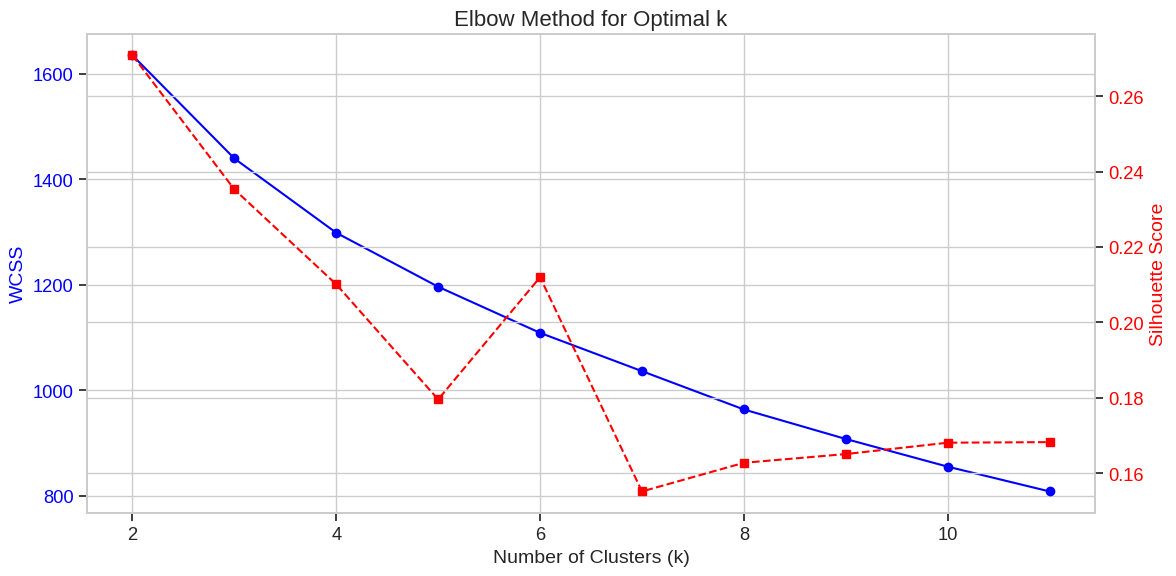

In [7]:
wcss = []
silhouette_scores = []
k_range = range(2, 12)
for k in k_range:
    kmeans = KMeans(n_clusters=k,n_init=10, random_state=42)
    kmeans.fit(X_pk_scaled)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_pk_scaled, kmeans.labels_))

    #---Plot the results---
fig,ax1 = plt.subplots(figsize=(12, 6))
    
    # plot WCSS(elbow method)
ax1.plot(k_range, wcss, marker='o', linestyle='-', color='b', label='WCSS (Elbow Method)')
ax1.set_xlabel('Number of Clusters (k)', fontsize=14)
ax1.set_ylabel('WCSS', color='b', fontsize=14)
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title('Elbow Method for Optimal k', fontsize=16)

    # plot Silhouette Scores
ax2 = ax1.twinx()
ax2.plot(k_range, silhouette_scores, marker='s', linestyle='--', color='r', label='Silhouette Score')
ax2.set_ylabel('Silhouette Score', color='r', fontsize=14)
ax2.tick_params(axis='y', labelcolor='r')

fig.tight_layout()
plt.show()

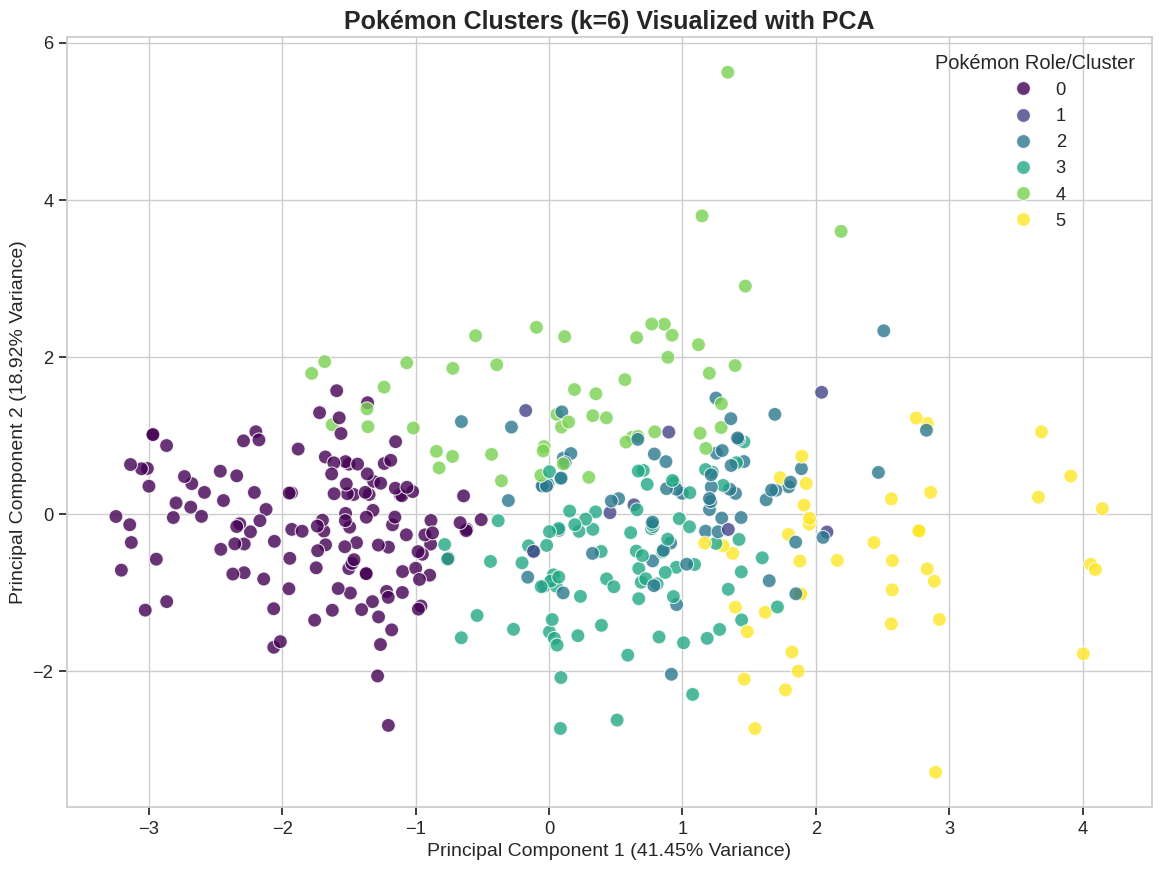

In [11]:
# Apply K-Means with the optimal k=6
k_optimal = 6
kmeans = KMeans(n_clusters=k_optimal, n_init=10, random_state=42)
pokemon_df['Cluster'] = kmeans.fit_predict(X_pk_scaled)

# --- Visualization using PCA ---
# Reduce the 6D scaled data to 2D using PCA
pca = PCA(n_components=2)
X_pk_pca = pca.fit_transform(X_pk_scaled)

# Create a new DataFrame for the PCA results
pca_df = pd.DataFrame(data=X_pk_pca, columns=['PC 1', 'PC 2'])
pca_df['Cluster'] = pokemon_df['Cluster']
pca_df['name'] = pokemon_df['name']

# Visualize the clusters in 2D
plt.figure(figsize=(14, 10))
sns.scatterplot(
    x='PC 1',
    y='PC 2',
    hue='Cluster',
    data=pca_df,
    palette='viridis',
    s=100,
    alpha=0.8
)

plt.title(f'Pokémon Clusters (k={k_optimal}) Visualized with PCA', fontsize=18, fontweight='bold')
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.2f}% Variance)', fontsize=14)
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.2f}% Variance)', fontsize=14)
plt.legend(title='Pokémon Role/Cluster')
plt.show()

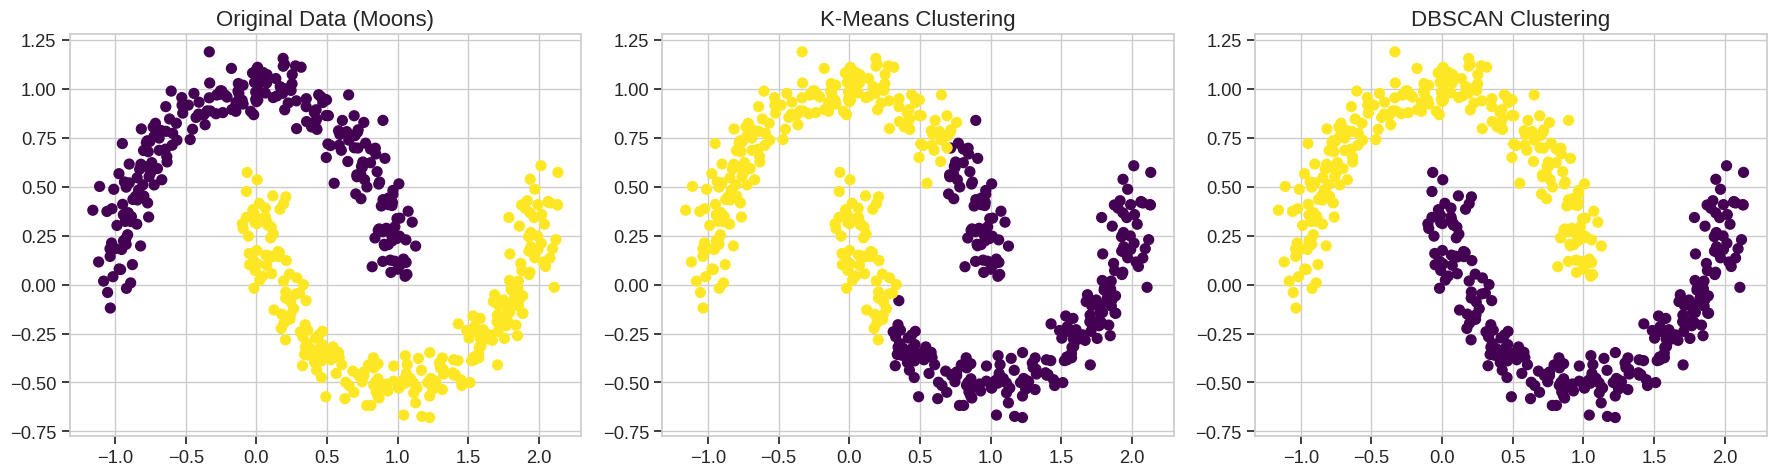

In [9]:
#make moon which is non-spherical data
x_moons, y_moons = make_moons(n_samples=500, noise=0.08, random_state=42)
#apply K-mean and DBSCAN

labels_km = KMeans(n_clusters=2, random_state=42).fit_predict(x_moons)
label_db = DBSCAN(eps=0.2, min_samples=5).fit_predict(x_moons)

#plot the results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
ax1.scatter(x_moons[:, 0], x_moons[:, 1], c=y_moons, cmap='viridis', s=50)
ax1.set_title('Original Data (Moons)', fontsize=16)
ax2.scatter(x_moons[:, 0], x_moons[:, 1], c=labels_km, cmap='viridis', s=50)
ax2.set_title('K-Means Clustering', fontsize=16)
ax3.scatter(x_moons[:, 0], x_moons[:, 1], c=label_db, cmap='viridis', s=50)
ax3.set_title('DBSCAN Clustering', fontsize=16)
plt.tight_layout()
plt.show()
